In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided

In [2]:
class Idns():
    """
    Non-stationarity index identification using modified run-test, as presented in [1,2,3].
    Standard deviation of entire signal is compared to standard deviation of segmented signal,
    and the number of variations (i.e., runs) is compared to expected value of variations to obtain
    the non-stationarity index.

    
    References
    ----------
    [1] L. Capponi, M. Česnik, J. Slavič, F. Cianetti, M. Boltežar.
        Non-stationarity index in vibration fatigue: Theoretical and experimental research.
        International Journal of Fatigue 104, 221-230.
    [2] M. Česnik, J. Slavič, L. Capponi, M. Palmieri, F. Cianetti, M. Boltežar.
        The relevance of non-stationarities and non-Gaussianities in vibration fatigue.
        MATEC Web of Conferences 165, 10011, 2018.
    [3] J. Slavič, M. Česnik, L. Capponi, M. Palmieri, F. Cianetti, M. Boltežar.
        Non-stationarity and non-Gaussianity in Vibration Fatigue.
        Sensors and Instrumentation, Aircraft/Aerospace, Energy Harvesting & Dynamic, 2020.
    """
    
    def __init__(self, x, nperseg, noverlap = 0, confidence = 95):
        
        """ 
        Get needed values from reference object

        Parameters
        ----------
        x : array_like
            Time series of measurement values

        nperseg : int
            Length of each segment
        
        noverlap: int, optional
            Number of points to overlap between segments. If None,
            "noverlap = 0". Defaults to None.

        confidence: int, optional
            Confidence interval [90-95-98-99] %. If None, 
            "confidence = 95". Defaults to None.
        

        Methods
        -------
        ._windowing       : Windowing of the signal
        
        ._run_computation : Run computation of a 1D array
        
        .nnst()           : Computation of non-stationarity index
        
        .get_index()      : float
                            Get the index of non-stationarity
        .get_segments()   : list[1D array, float, float]
                            Get segments standard deviations and lower and upper boundaries
        .get_limits()     : list[float, float]
                            Get lower and upper limits of non-stationarity
        
        .get_outcome()    : str
                            Get the outcome of the non-stationary test



        Raises
        ------
        ValueError : nperseg must be > 1
        ValueError : nperseg value must be less then len(x)
        ValueError : noverlap must be less than nperseg
        ValueError : confidence must be in [90, 95, 98, 99]
        
        """
        
        self.x = x
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.confidence = confidence
        
        if self.nperseg <= 1:
            raise ValueError('Input error: nperseg must be > 1')
            
        if self.noverlap is None:
            self.noverlap = 0
        elif self.noverlap >= self.nperseg:
            raise ValueError('Input error: noverlap must be less than nperseg.')
            
        if self.confidence is None:
            self.confidence = 95    
        elif self.confidence not in [90, 95, 98, 99]:
            raise ValueError('Input error: confidence must be in [90, 95, 98, 99]')
            
            
            
    def _windowing(self, x, nperseg, noverlap):
            
        seg = nperseg - noverlap
        new_shape = x.shape[:-1] + ((x.shape[-1] - noverlap) // seg, nperseg )
        new_strides = (x.strides[:-1] + (seg * x.strides[-1],) + x.strides[-1:])
        cls = as_strided(x, shape=new_shape, strides=new_strides)
                
        return cls
        
    def _run_computation(self, y, lower, upper):
            
        run = np.empty(len(y))
        N1 = N0 = Nr = 0
            
        for i in range(0, len(y)):
            if y[i] > upper or y[i] < lower:
                run[i] = 1
                N1 += 1
            else:
                run[i] = 0
                N0 += 1
                    
        if N1 + N0 == 0 or N1 + N0 == 1:
            raise ValueError('Error: nperseg value must be less then len(x)') 
                     
            
        for i in range(1, len(y)):
            if run[i] != run[i-1]:
                Nr += 1
        
               
        run_mean = (2 * N1 * N0) / (N1 + N0) + 1
        run_var = (2 * N1 * N0 * (2 * N1 * N0 - (N1 + N0))) / ((N1 + N0)**2 * (N1 + N0) - 1)
            
        return Nr, run_mean, run_var
        
    def nnst(self):
        
        N = len(self.x)
        std_entire = np.std(self.x, ddof = 1) 
        
        cls = self._windowing(self.x,self.nperseg,self.noverlap)
        
        self.std_seg = np.std(cls, axis=1, ddof=1)
        if N % self.nperseg != 0:
            res = self.x[N - N % self.nperseg:N]
            if len(res) != 1:
                self.std_seg = np.append(self.std_seg, np.std(res,ddof=1))
                
        self.std_UP = std_entire + np.std(self.std_seg, ddof = 1)
        self.std_DW = std_entire - np.std(self.std_seg, ddof = 1)
        
        self.Nr, self.run_mean, self.run_var = self._run_computation(self.std_seg, self.std_DW, self.std_UP)
        
        coeff = [1.645, 1.96, 2.326, 2.576]
        conf = [90, 95, 98, 99]
        alpha = coeff[conf.index(self.confidence)]
        
        lim_up = self.run_mean + alpha * np.sqrt(self.run_var)
        lim_dw = self.run_mean - alpha * np.sqrt(self.run_var)
        
        self.index_up = np.round(100 * lim_up / self.run_mean, 2)
        self.index_dw = np.round(100 * lim_dw / self.run_mean, 2)
        
        if self.Nr >= lim_dw and self.Nr <= lim_up:   
            self.outcome = 'Stationary'
        else:
            self.outcome = 'Non-stationary' 
            
        self.index = np.round( 100 * self.Nr / self.run_mean, 2)
        
    def get_segments(self):
        return [self.std_seg, self.std_DW, self.std_UP]
    
    def get_limits(self):
        return [self.index_dw, self.index_up]
    
    def get_index(self):
        return self.index
    
    def get_outcome(self):
        return self.outcome

In [6]:
T = 20
fs = 400
dt = 1 / fs
x = np.random.rand(T * fs)
time = np.linspace(0, T - dt, T * fs)
std = np.std(x, ddof = 1) 
mean = np.mean(x) 

a = Idns(x, nperseg = 2, noverlap = 0, confidence = 95)
a.nnst()

segments_std, bound_dw, bound_up = a.get_segments()
time_segments = np.linspace(0, T - dt, len(segments[0]))

limits = a.get_limits()
outcome = a.get_outcome()
index = a.get_index()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(time, x, color = 'darkgray', zorder = 0, label = 'Signal')
ax.plot(time_segments, mean + segments_std, color = 'C0', zorder = 1, label = 'Segments std')
ax.hlines(mean + std, 0, T, colors='C1', linestyles='solid', zorder = 2, label = 'Signal std')
ax.hlines(mean + bound_dw, 0, T, colors='C3', linestyles='dashed', zorder = 3, label = 'Boundaries')
ax.hlines(mean + bound_up, 0, T, colors='C3', linestyles='dashed', zorder = 4)
ax.grid()
ax.legend(loc = 4)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude [\]')
ax.set_title('Index: '+ str(index) + '%\n' + outcome)

Text(0.5, 1.0, 'Index: 101.46%\nStationary')

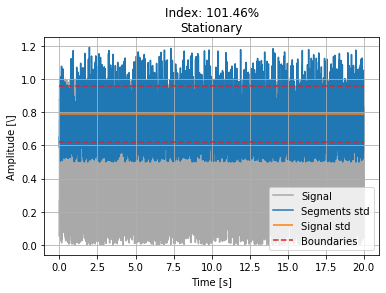

In [9]:

bound_dw

0.12294121227695912